# Aniso Clustering Lab

In [15]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from scipy import linalg
from scipy.spatial import distance
from sklearn.metrics import normalized_mutual_info_score

### Data Generation

In [17]:
n_samples = 1500  # Number of samples to generate
random_state = 17  # Set random seed for reproducibility

In [18]:
X, y = make_blobs(n_samples=n_samples, random_state=random_state)  # Generate isotropic Gaussian blobs for clustering
transformation = [[0.60834549, -0.63667641], [-0.40887718, 0.85253229]]  # Transformation matrix to introduce anisotropic distribution in data
X_aniso = np.dot(X, transformation)  # Apply the transformation to the data
y = list(y)  # Convert the true cluster labels (numpy array) to a list

### KMeans Clustering

In [19]:
kmeans = KMeans(n_clusters=3, random_state=random_state)  # Initialize the KMeans clustering model with 3 clusters and set a random state for reproducibility
y_pred_KMeans = kmeans.fit_predict(X_aniso)  # Fit the KMeans model to the dataset X_aniso and predict the cluster labels for each data point
y_pred_KMeans = list(y_pred_KMeans)  # Convert the predicted cluster labels (numpy array) to a list

### Gaussian Mixture Model Clustering

In [20]:
gmm = GaussianMixture(n_components=3, random_state=random_state)  # Initialize the Gaussian Mixture clustering model with 3 clusters and set a random state for reproducibility
y_pred_GMM = gmm.fit_predict(X_aniso)  # Fit the Gaussian Mixture model to the dataset X_aniso and predict the cluster labels for each data point
y_pred_GMM = list(y_pred_GMM)  # Convert the predicted cluster labels (numpy array) to a list

### Calculate RBF Kernel Matrix for Spectral Clustering

In [21]:
rbf_param = 7.6  # Set the parameter for the RBF
W = np.exp(-distance.cdist(X_aniso, X_aniso, 'sqeuclidean') / (2 * rbf_param ** 2))  # Calculate W_ij and form W matrix
D = np.diag(W.sum(axis=1))  # Calculate degree matrix for normalization

# Normalize the kernel matrix using the degree matrix
D_inv_sqrt = np.linalg.inv(np.sqrt(D))  # Calculate D^(-1/2)
M = np.dot(np.dot(D_inv_sqrt, W), D_inv_sqrt)  # Normalize the kernel matrix using the degree matrix (D^(-1/2)·W·D^(-1/2))

U = linalg.svd(M)  # Perform SVD to prepare for spectral clustering
Usubset = U[0][:, 0:3]  # Select the top 3 eigenvectors
y_pred_sc = KMeans(n_clusters=3, random_state=random_state).fit_predict(Usubset)  # KMeans clustering on the normalized eigenvectors for spectral clustering
y_pred_sc = list(y_pred_sc)  # Convert the predicted cluster labels (numpy array) to a list

### Sklearn Spectral Clustering

In [22]:
spectral = SpectralClustering(n_clusters=3, random_state=random_state, gamma=1 / (2 * rbf_param ** 2))  # Initialize a SpectralClustering model with 3 clusters, a specific random state for reproducibility and a gamma parameter
y_pred_sc_sklearn = spectral.fit_predict(X_aniso)  # Fit the model to the input data X_aniso and predict the cluster labels for each data point
y_pred_sc_sklearn = list(y_pred_sc_sklearn)  # Convert the predicted cluster labels (numpy array) to a list

### Data Visualization

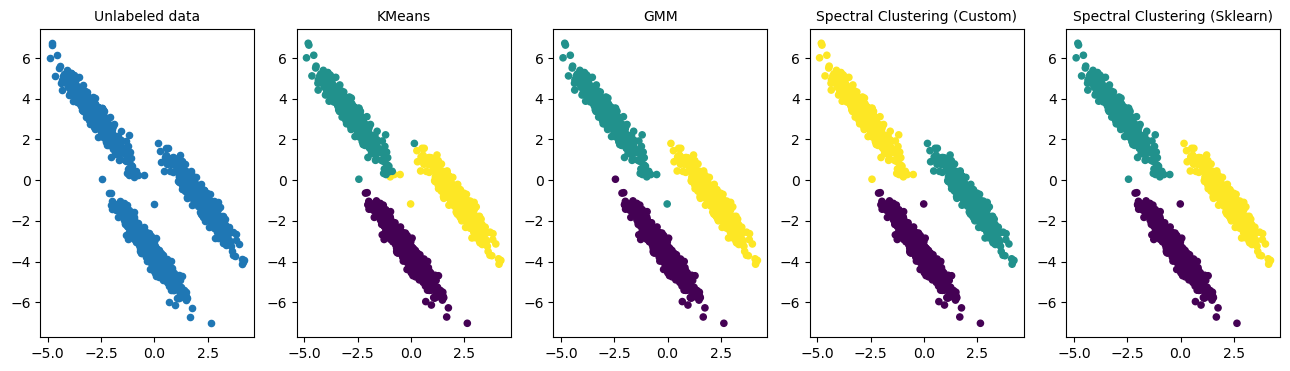

In [23]:
plt.figure(figsize=(16, 4))

# Plot initial unlabeled data with anisotropy
plt.subplot(1, 5, 1)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], s=20)
plt.title('Unlabeled data', fontsize=10)

# Plot KMeans clustering result
plt.subplot(1, 5, 2)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred_KMeans, s=20)  # Plot KMeans clustering result
plt.title('KMeans', fontsize=10)

# Plot GMM clustering result
plt.subplot(1, 5, 3)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred_GMM, s=20)  # Plot GMM clustering result
plt.title('GMM', fontsize=10)

# Plot custom spectral clustering result
plt.subplot(1, 5, 4)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred_sc, s=20)  # Plot custom spectral clustering result
plt.title('Spectral Clustering (Custom)', fontsize=10)

# Plot sklearn spectral clustering result
plt.subplot(1, 5, 5)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred_sc_sklearn, s=20)  # Plot Sklearn spectral clustering result
plt.title('Spectral Clustering (Sklearn)', fontsize=10)

plt.show()

### Calculate the Normalized Mutual Information Score

In [24]:
nmi_kmeans = normalized_mutual_info_score(y, y_pred_KMeans)
nmi_gmm = normalized_mutual_info_score(y, y_pred_GMM)
nmi_spectral_custom = normalized_mutual_info_score(y, y_pred_sc)
nmi_spectral_sklearn = normalized_mutual_info_score(y, y_pred_sc_sklearn)

print('NMI (KMeans):', nmi_kmeans)
print('NMI (GMM):', nmi_gmm)
print('NMI (Spectral Clustering - Custom):', nmi_spectral_custom)
print('NMI (Spectral Clustering - Sklearn):', nmi_spectral_sklearn)

NMI (KMeans): 0.9771034898395968
NMI (GMM): 1.0
NMI (Spectral Clustering - Custom): 0.9912451887343161
NMI (Spectral Clustering - Sklearn): 0.9912451887343161
